In [1]:
import numpy as np
import osr_methods as osr
import ocr_methods as ocr
import matplotlib.pyplot as plt
from timeit import default_timer as timer

### Definição do Ponto Inicial

In [2]:
#exterior
#x = np.array([14., 6.])
x = np.array([10., -1.])

#interior
#x = np.array([30., 20.])

### Escolha dos métodos de OSR e OCR

In [3]:
# Metodos OCR
# 1 - Penalidade
# 2 - Barreira
metodo_ocr = 1

if (metodo_ocr == 1):
    n_met_ocr = "Penalidade"
elif (metodo_ocr == 2):
    n_met_ocr = "Barreira"

# Metodos OSR
# 1 - Univariante
# 2 - Powell
# 3 - Stepest Descent
# 4 - Newton-Raphson
# 5 - Fletcher-Reeves
# 6 - BFGS
metodo_osr = 4

if (metodo_osr == 1):
    n_met = 'Univariante'
elif (metodo_osr == 2):
    n_met = 'Powell'
elif (metodo_osr == 3):
    n_met = 'Steepest Descent'
elif (metodo_osr == 4):
    n_met = 'Newton-Raphson'
elif (metodo_osr == 5):
    n_met = 'Fletcher-Reeves'
elif (metodo_osr == 6):
    n_met = 'BFGS'

### Controle Numérico

In [4]:
# numero maximo de iteracoes na OSR
maxiter = 1000

# tolerancia para convergencia do gradiente na OSR
tol_conv = 1E-3

# tolerancia para a busca unidirecional na OSR
tol_search = 1E-8

# delta alpha do passo constante na OSR
line_step = 1E-4

#epsilon da maquina
eps = 1E-10

#parametros ocr
if metodo_ocr == 1:
    #penalidade
    r = 1.
    beta = 10
elif metodo_ocr == 2:
    #barreira
    r = 10.
    beta = 0.1

#tolerancia OCR
tol = 1E-3

ctrl_num_osr = [maxiter, tol_conv, tol_search, line_step, eps]

### Definição de f

In [5]:
def f(x):
    return (x[0] - 10)**3 + (x[1] - 20)**3

def grad_f(x):
    a = 3*(x[0] - 10)**2
    b = 3*(x[1] - 20)**2
    return np.array([a, b])

def hess_f(x):
    #termo 1x1
    a = 6*(x[0] - 10)
    #termo 1x2
    b = 0.
    #termo 2x1
    c = 0.
    #termo 2x2
    d = 6*(x[1] - 20)
    
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    return hess

### Definição das restrições de desigualdade

In [6]:
def cl1(x):
    return 100 - (x[0] - 5)**2 - (x[1] - 5)**2

def grad_cl1(x):
    a = -2*(x[0] - 5)
    b = -2*(x[1] - 5)
    return np.array([a, b])

def hess_cl1(x):
    #termo 1x1
    a = -2.
    #termo 1x2
    b = 0.
    #termo 2x1
    c = 0.
    #termo 2x2
    d = -2.
    
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    return hess

def cl2(x):
    return -82.81 + (x[0] - 6)**2 + (x[1] - 5)**2

def grad_cl2(x):
    a = 2*(x[0] - 6)
    b = 2*(x[1] - 5)
    return np.array([a, b])

def hess_cl2(x):
    #termo 1x1
    a = 2.
    #termo 1x2
    b = 0.
    #termo 2x1
    c = 0.
    #termo 2x2
    d = 2.
    
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    
    return hess

def cl3(x):
    return 13 - x[0]

def grad_cl3(x):
    a = -1.
    b= 0.
    return np.array([a, b])

def hess_cl3(x):
    return np.zeros((2,2), dtype=float)

def cl4(x):
    return x[0] - 100

def grad_cl4(x):
    a = 1.
    b = 0.
    return np.array([a, b])

def hess_cl4(x):
    return np.zeros((2,2), dtype=float)

def cl5(x):
    return -x[1]

def grad_cl5(x):
    a = 0.
    b = -1.
    return np.array([a, b])

def hess_cl5(x):
    return np.zeros((2,2), dtype=float)

def cl6(x):
    return x[1] - 100

def grad_cl6(x):
    a = 0.
    b = 1.
    return np.array([a, b])

def hess_cl6(x):
    return np.zeros((2,2), dtype=float)

### Listas de Restrições e suas derivadas

In [7]:
hk_list = []
grad_hk_list = []
hess_hk_list = []

cl_list = [cl1, cl2, cl3, cl4, cl5, cl6]
grad_cl_list = [grad_cl1, grad_cl2, grad_cl3, grad_cl4, grad_cl5, grad_cl6]
hess_cl_list = [hess_cl1, hess_cl2, hess_cl3, hess_cl4, hess_cl5, hess_cl6]

#para o metodo de penalidade
#controle de quais cls irao montar a phi
cl_mont = []
if metodo_ocr == 1:
    for cl in cl_list:
        if cl(x) > 0:
            cl_mont.append(1)
        else:
            cl_mont.append(0)
            
params = [f, grad_f, hess_f, hk_list, grad_hk_list, hess_hk_list, cl_list, grad_cl_list, hess_cl_list, cl_mont]


### Otimização

In [8]:

if metodo_ocr == 1:
    parc = (1/2)*r*ocr.p_penal(x, params)
elif metodo_ocr == 2:
    parc = r*ocr.b_bar(x, params)
    
listP_OCR = []
listP_OCR.append(x)

listResultsOSR = []

passos_OCR = 0
redo = 0
print(n_met)
while(parc > tol):
    passos_OCR = passos_OCR + 1
    if passos_OCR > 1:
        r = beta*r
        # for i in np.arange(len(levellist)):
        #     levellist[i] = beta*levellist[i]
        if metodo_ocr == 1:
            cl_mont = []
            for cl in cl_list:
                if cl(x) > 0:
                    cl_mont.append(1)
                else:
                    cl_mont.append(0)
    listP_OSR, passos_OSR, conv_OSR, flag_conv_OSR, tempoExec_OSR = osr.osr_ctrl(x, params, r, ctrl_num_osr, metodo_ocr, metodo_osr)
    
    if metodo_ocr == 2:
        redo = 0
        for cl in cl_list:
            if cl(listP_OSR[-1]) > 0:
                redo = 1
                break
    if (redo == 0):
        ctrl_num_osr[3] = line_step
        x = listP_OSR[-1]
        listP_OCR.append(x)
        listResultsOSR.append([listP_OSR, params, r, metodo_ocr, metodo_osr])
        if metodo_ocr == 1:
            parc = (1/2)*r*ocr.p_penal(x, params)
        elif metodo_ocr == 2:
            parc = r*ocr.b_bar(x, params)
        print(f'{passos_OCR}: x={x}, r={r:.1e}, passos={passos_OSR}, conv_OCR={parc:.4e}, conv_OSR={conv_OSR:.4e}')
    elif (redo == 1):
        print(f'Refazendo passo {passos_OCR} com delta alpha = {0.1*ctrl_num_osr[3]}')
        passos_OCR = passos_OCR - 1
        r = r/beta
        ctrl_num_osr[3] = 0.1*ctrl_num_osr[3]
        
        
        plt.close()
    

Newton-Raphson
1: x=[ 4.55138195 -8.77115736], r=1.0e+00, passos=8, conv_OCR=4.1103e+03, conv_OSR=7.1048e-04
2: x=[ 5.03108451 -5.44207259], r=1.0e+01, passos=17, conv_OCR=8.7401e+02, conv_OSR=4.7042e-04
3: x=[ 8.26456762 -4.48968057], r=1.0e+02, passos=10, conv_OCR=2.1544e+03, conv_OSR=5.4066e-04
4: x=[12.82279707 -1.23005973], r=1.0e+03, passos=8, conv_OCR=7.7227e+02, conv_OSR=9.8803e-04
5: x=[13.41829627 -0.39511216], r=1.0e+04, passos=6, conv_OCR=1.6586e+03, conv_OSR=1.6469e-04
6: x=[13.47279595 -0.30884231], r=1.0e+05, passos=1000, conv_OCR=1.5985e+04, conv_OSR=6.7103e-02
7: x=[13.47818743 -0.30020138], r=1.0e+06, passos=1000, conv_OCR=1.5979e+05, conv_OSR=9.6004e-01
8: x=[13.47872599 -0.29933716], r=1.0e+07, passos=1000, conv_OCR=1.5979e+06, conv_OSR=2.6361e+00
9: x=[13.47877984 -0.29925074], r=1.0e+08, passos=1000, conv_OCR=1.5979e+07, conv_OSR=5.0925e+01
10: x=[13.47878522 -0.2992421 ], r=1.0e+09, passos=1000, conv_OCR=1.5979e+08, conv_OSR=5.1622e+02
11: x=[13.47878576 -0.29924

KeyboardInterrupt: 

### Plots de $\phi(x_1,x_2)$ e restrições

In [ ]:
# x1 = np.linspace(0.01,10)
# x2 = np.linspace(0.01,60)
# X1, X2 = np.meshgrid(x1, x2)
# #levellist = [0,50,100,400,800,2000]

# levellist = [0,50, 100, 200, 400 , 600, 1000]

# n_plots = passos_OCR

# fig, ax = plt.subplots(int(np.ceil(n_plots/2)), 2, sharex='col', sharey='row')


# k = 0
# for i in np.arange(int(np.ceil(n_plots/2))):
#     for j in [0,1]:
#         if metodo_ocr == 1:
#             X3 = ocr.phi_penal([X1,X2], listResultsOSR[k][1], listResultsOSR[k][2])
#         elif metodo_ocr == 2:
#             X3 = ocr.phi_bar([X1, X2], listResultsOSR[k][1], listResultsOSR[k][2])
#         niveis = ax[i,j].contour(X1, X2, X3, levellist, colors='black')
#         ax[i,j].clabel(niveis, inline=1, fontsize=8)
#         for hk in hk_list:
#             X3 = hk([X1,X2])
#             ax[i,j].contour(X1, X2, X3, [0], colors='red')
    
#         for cl in cl_list:
#             X3 = cl([X1,X2])
#             ax[i,j].contour(X1, X2, X3, [0], colors='blue')
           
#         x = []
#         y = []
#         for P in listResultsOSR[k][0]:
#             x.append(P[0])
#             y.append(P[1])
#         ax[i,j].plot(x, y, color='g', linewidth='3')
#         #ax[i,j].set_xlabel('$x_1$', fontsize='10')
#         #ax[i,j].set_ylabel('$x_2$', fontsize='10')
#         ax[i,j].grid(linestyle='--')
#         #ax[i,j].set_xticks([-5,-2,0,2,5])
#         titulo = 'Passo ' + str(k+1)
#         ax[i,j].set_title(titulo, fontsize=12)
#         k = k + 1
        
#         # if (metodo_ocr == 1):
#         #      for l in np.arange(len(levellist)):
#         #         levellist[l] = beta*levellist[l]/2
        
#         if k > n_plots - 1:
#             break
#     if k > n_plots - 1:
#         break

# titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ')
# fig.suptitle(titulo, fontsize=14)
# fig.tight_layout()
# plt.figure(figsize=(10,20))
# plt.show()

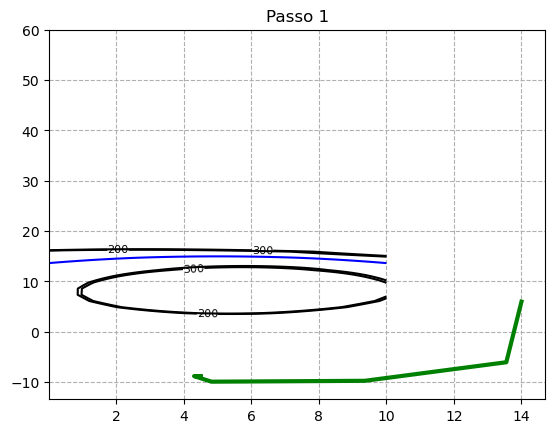

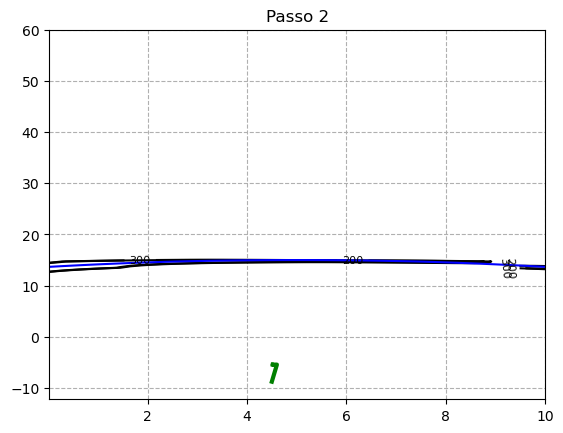

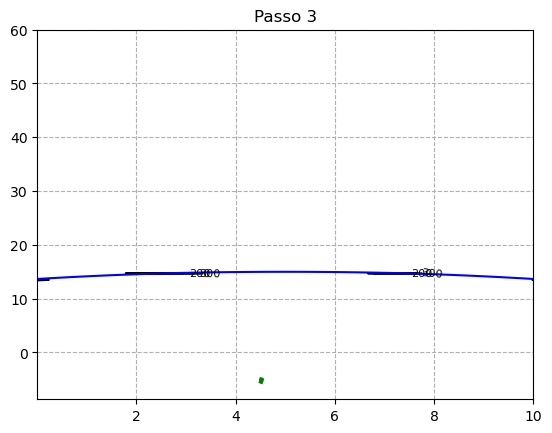

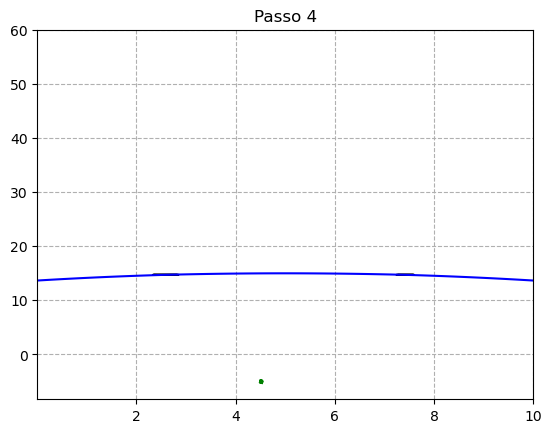

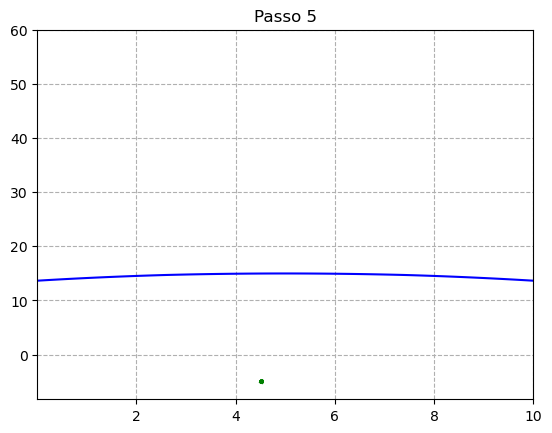

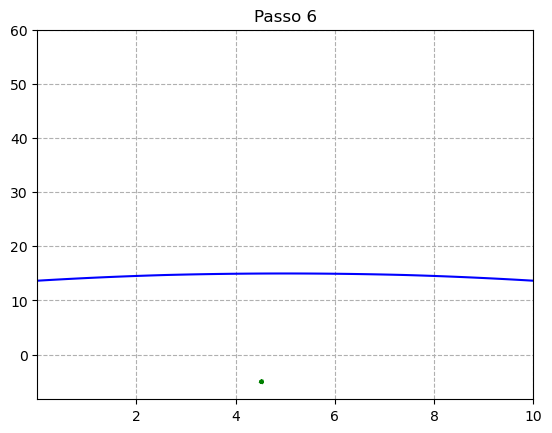

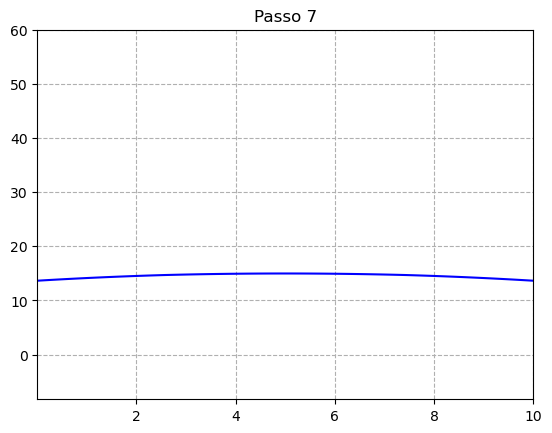

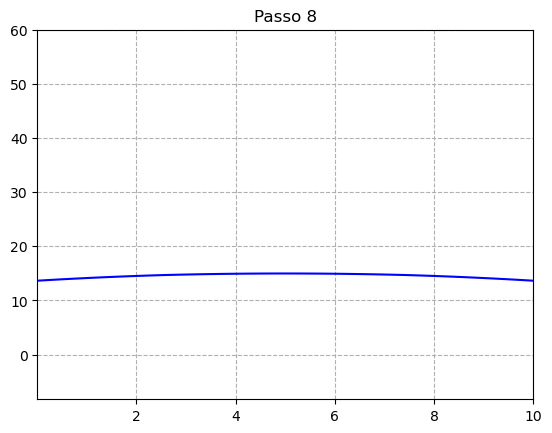

In [ ]:
x1 = np.linspace(0.01,10)
x2 = np.linspace(0.01,60)
X1, X2 = np.meshgrid(x1, x2)
#levellist = [0,50,100,400,800,2000]

levellist = [200, 300]

n_plots = passos_OCR
k=0
for item in listResultsOSR :
    
    fig, ax = plt.subplots()

    if metodo_ocr == 1:
        X3 = ocr.phi_penal([X1,X2], item[1], item[2])
    elif metodo_ocr == 2:
        X3 = ocr.phi_bar([X1, X2], item[1], item[2])
    niveis = ax.contour(X1, X2, X3, levellist, colors='black')
    ax.clabel(niveis, inline=1, fontsize=8)
    for hk in hk_list:
        X3 = hk([X1,X2])
        ax.contour(X1, X2, X3, [0], colors='red')
    
    for cl in cl_list:
        X3 = cl([X1,X2])
        ax.contour(X1, X2, X3, [0], colors='blue')
           
    x = []
    y = []
    for P in item[0]:
        x.append(P[0])
        y.append(P[1])
    ax.plot(x, y, color='g', linewidth='3')
    #ax[i,j].set_xlabel('$x_1$', fontsize='10')
    #ax[i,j].set_ylabel('$x_2$', fontsize='10')
    ax.grid(linestyle='--')
    #ax[i,j].set_xticks([-5,-2,0,2,5])
    titulo = 'Passo ' + str(k+1)
    ax.set_title(titulo, fontsize=12)
    k = k+1
        
        # if (metodo_ocr == 1):
        #      for l in np.arange(len(levellist)):
        #         levellist[l] = beta*levellist[l]/2
        
  

# titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ')
# fig.suptitle(titulo, fontsize=14)
# fig.tight_layout()
# plt.figure(figsize=(10,20))
plt.show()

### Plot de $f(x_1, x_2)$ e restrições

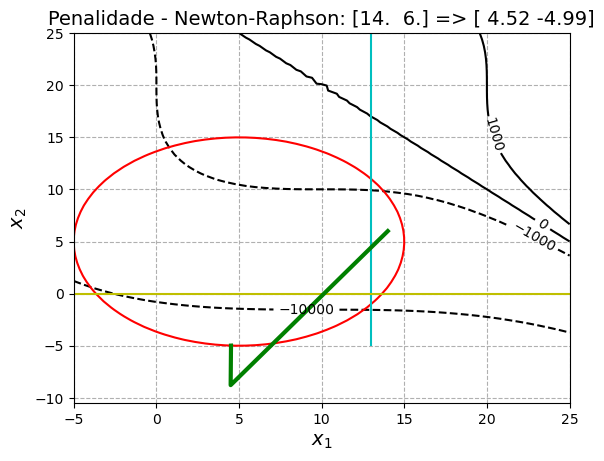

In [ ]:
x1 = np.linspace(-5,25)
x2 = np.linspace(-5,25)
X1, X2 = np.meshgrid(x1, x2)
#levellist = [5,15,25,35,45,55,65]

X3 = f([X1, X2])
    
figura, ax = plt.subplots()
        
niveis = ax.contour(X1, X2, X3, [-50000,-10000,-1000,0,1000,10000, 50000, 100000,300000,500000],colors='black')
ax.clabel(niveis, inline=1, fontsize=10)

X3 = cl1([X1,X2])
plt.contour(X1, X2, X3, [0], colors='r')

X3 = cl2([X1,X2])
plt.contour(X1, X2, X3, [0], colors='b')

X3 = cl3([X1,X2])
plt.contour(X1, X2, X3, [0], colors='c')

X3 = cl4([X1,X2])
plt.contour(X1, X2, X3, [0], colors='m')

X3 = cl5([X1,X2])
plt.contour(X1, X2, X3, [0], colors='y')

X3 = cl6([X1,X2])
plt.contour(X1, X2, X3, [0], colors='brown')

x = []
y = []
for P in listP_OCR:
    x.append(P[0])
    y.append(P[1])

ax.plot(x, y, color='g', linewidth='3')
ax.set_xlabel('$x_1$', fontsize='14')
ax.set_ylabel('$x_2$', fontsize='14')
ax.grid(linestyle='--')
titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ') 
ax.set_title(titulo, fontsize='14')
plt.show()

